In [9]:
# %%
# 单元格 1: 配置环境
# 运行此单元格将安装 (或更新) 我们需要的库
# SciPy 是一个大型科学计算库，包含了信号处理和优化
# !!! 修复: 添加 openpyxl 用于支持 .to_excel() !!!
print("Installing pandas, matplotlib, numpy, scipy, openpyxl...")
!pip install --upgrade pandas matplotlib numpy scipy openpyxl
print("Installation complete!")

Installing pandas, matplotlib, numpy, scipy, openpyxl...
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

Installation complete!


In [10]:
# %%
# 单元格 2: 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# 导入 SciPy 中的“寻峰器”
from scipy.signal import find_peaks

# 导入 SciPy 中的“拟合器”
from scipy.optimize import curve_fit

# 设置 matplotlib 在 notebook 中内联显示
%matplotlib inline
plt.style.use('seaborn-v0_8-ticks')

print("核心库导入成功！准备开始。")

核心库导入成功！准备开始。


Generating simulated CV data...
Successfully generated CV data file in 'my_cv_data'.


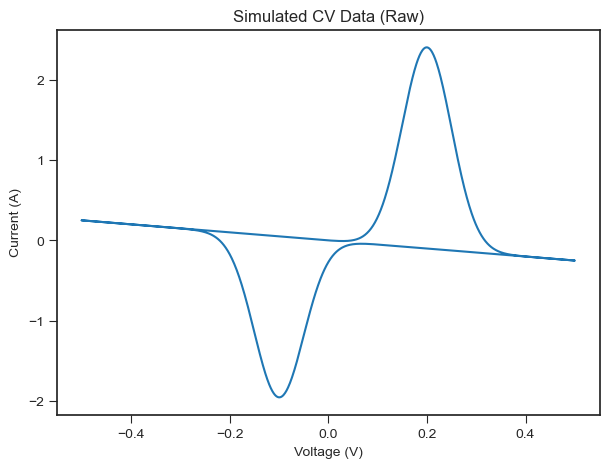

In [16]:
# %%
# 单元格 3: 模拟生成一份CV数据
# (我们将模拟一个包含氧化峰和还原峰的CV曲线)

print("Generating simulated CV data...")
data_dir_cv = "my_cv_data"
os.makedirs(data_dir_cv, exist_ok=True)

# 1. 定义高斯函数 (模拟峰)
def gaussian(x, amp, center, sigma):
    return amp * np.exp(-((x - center) ** 2) / (2 * sigma ** 2))

# 2. 模拟电位扫描范围
voltage = np.linspace(-0.5, 0.5, 1000)

# 3. 模拟背景电流 (电容行为，一条斜线)
baseline = -0.5 * voltage

# 4. 模拟一个氧化峰 (正向扫) 和一个还原峰 (反向扫)
# 假设电位从-0.5 -> 0.5 -> -0.5
v_forward = voltage
i_forward = baseline + gaussian(v_forward, 2.5, 0.2, 0.05) # 氧化峰 @ 0.2V

v_backward = voltage[::-1] # 反向电位
i_backward = baseline[::-1] - gaussian(v_backward, 2.0, -0.1, 0.05) # 还原峰 @ -0.1V

# 5. 合并数据
# 我们模拟仪器导出的两列数据：电位(V) 和 电流(I)
v_full = np.concatenate((v_forward, v_backward))
i_full = np.concatenate((i_forward, i_backward))

# 6. 组装成 DataFrame
df_cv = pd.DataFrame({
    'Voltage (V)': v_full,
    'Current (A)': i_full
})

# 7. 保存到 .txt 文件
filename_cv = os.path.join(data_dir_cv, "Sample_CV_Cycle_1.txt")
df_cv.to_csv(filename_cv, sep='\t', index=False)

print(f"Successfully generated CV data file in '{data_dir_cv}'.")

# 8. (可选) 绘制我们模拟的CV数据看看
plt.figure(figsize=(7, 5))
plt.plot(df_cv['Voltage (V)'], df_cv['Current (A)'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('Simulated CV Data (Raw)')
plt.show()

--- Starting Auto CV Peak-Finding ---
Found 1 oxidation peaks
Found 1 reduction peaks
  - Oxidation peak at: V = 0.200 V, I = 2.400 A
  - Reduction peak at: V = -0.100 V, I = -1.950 A


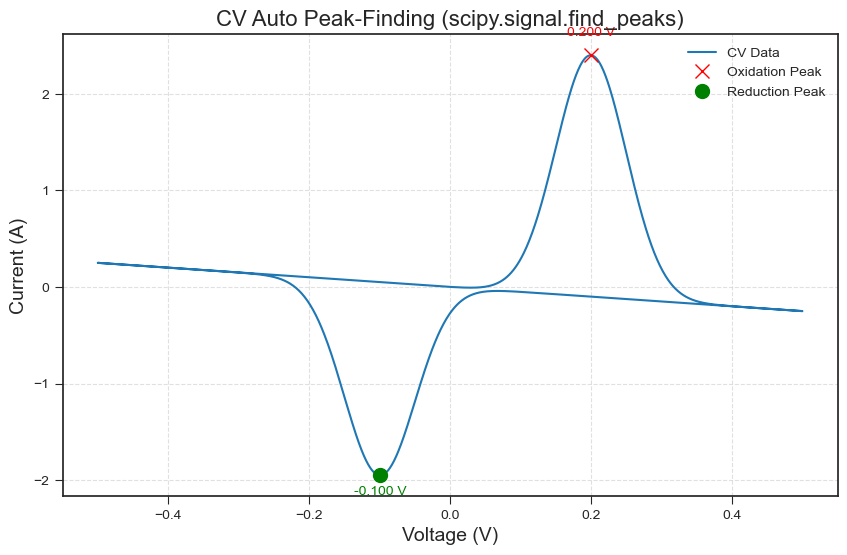

In [17]:
# %%
# 单元格 4: CV 自动寻峰实战

print("--- Starting Auto CV Peak-Finding ---")

# 1. 读取数据 (这里我们只处理刚才生成的那个文件)
data_cv = pd.read_csv(filename_cv, sep='\t')
voltage = data_cv['Voltage (V)']
current = data_cv['Current (A)']

# 2. 使用 find_peaks 自动寻找“氧化峰”
# 氧化峰是正向的峰 (current 值大)
# prominence=0.5 表示峰高至少要比周围突起0.5个单位
# width=10 表示峰的宽度至少要有10个数据点
# 这样可以过滤掉小的噪声峰
peaks_oxidation, _ = find_peaks(current, prominence=0.5, width=10)

# 3. 使用 find_peaks 自动寻找“还原峰”
# 还原峰是反向的峰 (current 值小)
# 我们只需要把电流数据取反 (-current)，就能用同样的函数找“正峰”
peaks_reduction, _ = find_peaks(-current, prominence=0.5, width=10)

print(f"Found {len(peaks_oxidation)} oxidation peaks")
print(f"Found {len(peaks_reduction)} reduction peaks")

# 4. 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(voltage, current, label='CV Data')

# 在图上标记找到的峰
plt.plot(voltage[peaks_oxidation], current[peaks_oxidation], 'x', color='red', markersize=10, label='Oxidation Peak')
plt.plot(voltage[peaks_reduction], current[peaks_reduction], 'o', color='green', markersize=10, label='Reduction Peak')

# 打印峰值信息
for p in peaks_oxidation:
    print(f"  - Oxidation peak at: V = {voltage[p]:.3f} V, I = {current[p]:.3f} A")
    plt.text(voltage[p], current[p] + 0.2, f'{voltage[p]:.3f} V', ha='center', color='red')
  
for p in peaks_reduction:
    print(f"  - Reduction peak at: V = {voltage[p]:.3f} V, I = {current[p]:.3f} A")
    plt.text(voltage[p], current[p] - 0.2, f'{voltage[p]:.3f} V', ha='center', color='green')

plt.xlabel('Voltage (V)', fontsize=14)
plt.ylabel('Current (A)', fontsize=14)
plt.title('CV Auto Peak-Finding (scipy.signal.find_peaks)', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
# %%
# 单元格 5: 模拟生成一批EIS数据 (Randles电路)
# 我们将模拟一个简单的 Randles 电路: R_s + (R_ct || CPE)
# 我们将模拟3个文件，代表R_ct(电荷转移电阻)在老化过程中逐渐增大

print("开始生成模拟EIS数据...")
data_dir_eis = "my_eis_data"
os.makedirs(data_dir_eis, exist_ok=True)

# 1. 定义等效电路模型函数 (返回复数阻抗)
def randles_circuit(freq, R_s, R_ct, Q, n):
    """
    Randles电路模型： R_s + (R_ct || CPE)
    freq: 频率 (Hz)
    R_s: 溶液电阻 (Ohm)
    R_ct: 电荷转移电阻 (Ohm)
    Q: CPE 元件的电容值
    n: CPE 元件的弥散指数 (0-1)
    """
    omega = 2 * np.pi * freq  # 角频率
  
    # 模拟CPE (常相位角元件) 阻抗
    # Z_cpe = 1 / (Q * (j*omega)^n)
    Z_cpe = 1 / (Q * ((1j * omega) ** n))
  
    # R_ct 和 CPE 并联，然后再与 R_s 串联
    Z = R_s + (1 / (1/R_ct + 1/Z_cpe))
  
    return Z

# 2. 定义频率范围 (100kHz 到 0.1Hz)
frequencies = np.logspace(5, -1, 100)

# 3. 模拟3个不同 R_ct 值的文件
R_ct_values = [100, 200, 400] # 模拟电阻增大的过程
R_s_true = 20
Q_true = 1e-5
n_true = 0.85

file_list_eis = []

for i, r_ct in enumerate(R_ct_values):
  
    # 4. 计算“完美”的阻抗
    Z_complex = randles_circuit(frequencies, R_s_true, r_ct, Q_true, n_true)
  
    # 5. 提取实部和虚部
    Z_real = Z_complex.real
    Z_imag = Z_complex.imag
  
    # 6. 模拟仪器的测量噪声
    noise_real = np.random.normal(0, 0.5, frequencies.shape)
    noise_imag = np.random.normal(0, 0.5, frequencies.shape)
  
    # 7. 组装成 DataFrame
    df_eis = pd.DataFrame({
        'Frequency (Hz)': frequencies,
        'Z_real (Ohm)': Z_real + noise_real,
        'Z_imag (Ohm)': Z_imag + noise_imag
    })
  
    # 8. 保存到 .txt 文件
    filename_eis = os.path.join(data_dir_eis, f"Sample_EIS_State_{i+1}.txt")
    df_eis.to_csv(filename_eis, sep='\t', index=False)
    file_list_eis.append(filename_eis)

print(f"成功在 '{data_dir_eis}' 文件夹中生成了 {len(R_ct_values)} 个模拟EIS文件。")

开始生成模拟EIS数据...
成功在 'my_eis_data' 文件夹中生成了 3 个模拟EIS文件。


In [14]:
# %%
# 单元格 6: 定义 curve_fit 需要的拟合函数
# curve_fit 不能直接处理复数，所以我们要一个小技巧：
# 把 Z_real 和 Z_imag "堆叠" 在一起拟合

def fit_func_eis(frequency, R_s, R_ct, Q, n):
    """
    这是专门给 curve_fit 用的函数
    输入 (x): frequency (1D 数组)
    输入 (params): R_s, R_ct, Q, n
    输出 (y): Z_real 和 Z_imag 堆叠在一起的 1D 数组
    """
  
    # 1. 用我们的物理模型计算复数阻抗
    Z_complex = randles_circuit(frequency, R_s, R_ct, Q, n)
  
    # 2. 提取实部和虚部
    Z_real_model = Z_complex.real
    Z_imag_model = Z_complex.imag
  
    # 3. 堆叠并返回
    # [Z_real_1, Z_real_2, ... , Z_imag_1, Z_imag_2, ...]
    return np.concatenate((Z_real_model, Z_imag_model))

print("EIS拟合模型函数 'fit_func_eis' 定义成功。")

EIS拟合模型函数 'fit_func_eis' 定义成功。


--- Starting Batch EIS Fitting (scipy.optimize.curve_fit) ---


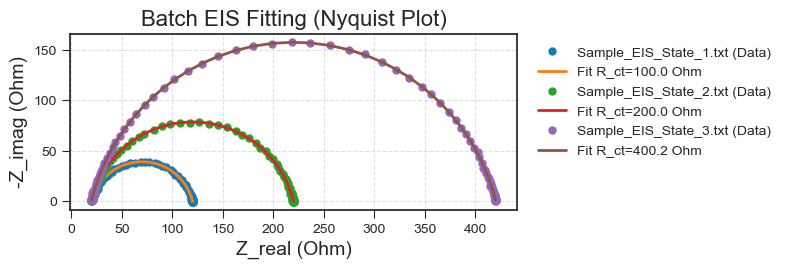


--- Batch Fit Results Summary ---
                file_name  R_s (Ohm)  R_ct (Ohm)        Q         n
0  Sample_EIS_State_1.txt  19.953937  100.025808  0.00001  0.848561
1  Sample_EIS_State_2.txt  19.932921  200.024927  0.00001  0.849351
2  Sample_EIS_State_3.txt  19.865890  400.161375  0.00001  0.849364

Fit results saved to: eis_batch_fit_results.xlsx


In [15]:
# %%
# 单元格 7: 批量拟合EIS实战与绘图

print("--- Starting Batch EIS Fitting (scipy.optimize.curve_fit) ---")

# 1. 创建一个列表，用于存储所有拟合结果
batch_fit_results = []

# 2. 创建一个图，用于绘制所有Nyquist图
fig, ax = plt.subplots(figsize=(8, 8))

# 3. 遍历所有EIS文件 (我们用 单元格 5 生成的 file_list_eis)
for file_path in file_list_eis:
    
    # 4. (Pandas) 读取数据
    data_eis = pd.read_csv(file_path, sep='\t')
    
    # !!! 核心修复: 必须转为 .values (numpy array) 才能喂给 scipy !!!
    # 否则会报 'Series' object has no attribute 'real' 错误
    freq = data_eis['Frequency (Hz)'].values
    z_real_data = data_eis['Z_real (Ohm)'].values
    z_imag_data = data_eis['Z_imag (Ohm)'].values
    
    # 5. 准备 curve_fit 的输入
    # x_data 是频率
    x_data = freq
    # y_data 是 实部 和 虚部 堆叠起来的数据
    y_data = np.concatenate((z_real_data, z_imag_data))
    
    # 6. 定义拟合的“初始猜测值” (p0)
    # R_s, R_ct, Q, n
    initial_guesses = [10, 150, 1e-6, 0.8] 
    
    # 7. (SciPy) 运行拟合！
    # popt: 拟合得到的最佳参数 [R_s, R_ct, Q, n]
    # pcov: 协方差矩阵，用于估算误差 (我们暂时不用)
    try:
        popt, pcov = curve_fit(
            fit_func_eis,     # 我们定义的拟合函数
            x_data,           # X_data (频率)
            y_data,           # Y_data (Z_real + Z_imag)
            p0=initial_guesses # 初始猜测
        )
        
        # 8. 存储拟合结果
        fit_params = {
            'file_name': os.path.basename(file_path),
            'R_s (Ohm)': popt[0],
            'R_ct (Ohm)': popt[1],
            'Q': popt[2],
            'n': popt[3]
        }
        batch_fit_results.append(fit_params)
        
        # 9. 绘制数据 (点)
        # Nyquist图 Y轴是 -Z_imag
        label = f"{os.path.basename(file_path)} (Data)"
        ax.plot(z_real_data, -z_imag_data, 'o', markersize=5, label=label)
        
        # 10. 绘制拟合曲线 (线)
        # 用拟合得到的参数 (popt) 来生成拟合曲线
        y_fit = fit_func_eis(freq, *popt)
        # 拆分 Z_real_fit 和 Z_imag_fit
        z_real_fit, z_imag_fit = np.split(y_fit, 2)
        
        label_fit = f"Fit R_ct={popt[1]:.1f} Ohm"
        ax.plot(z_real_fit, -z_imag_fit, '-', linewidth=2, label=label_fit)
        
    except RuntimeError as e:
        print(f"File {file_path} fitting failed: {e}")

# 11. 绘图收尾
ax.set_xlabel('Z_real (Ohm)', fontsize=14)
ax.set_ylabel('-Z_imag (Ohm)', fontsize=14)
ax.set_title('Batch EIS Fitting (Nyquist Plot)', fontsize=16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_aspect('equal') # Nyquist图必须是正方形
plt.tight_layout()
plt.show()

# 12. (Pandas) 将所有拟合结果转换成一个漂亮的表格
df_results = pd.DataFrame(batch_fit_results)

print("\n--- Batch Fit Results Summary ---")
print(df_results)

# 13. (可选) 保存结果到Excel
output_excel = "eis_batch_fit_results.xlsx"
df_results.to_excel(output_excel, index=False)
print(f"\nFit results saved to: {output_excel}")